## Knock Out Rules optimisation through NGSA II-Pretrained Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  
import kooptimize.NGSAII as ngsa2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from random import randint
from sklearn.model_selection import RandomizedSearchCV
import time

### Pre-trained Model:
1. Split the dataset as KO Rules + CV trained model.
2. Optimise KO rule on the dataset not used for model training, using the trained model.


### Read and Process data 

In [2]:
data = pd.read_csv('data/train_fin_cols.csv')

y_org = data['loan_default']
X_org = data.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(X_org.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

X_org = X_org.drop(categorical_columns_to_drop,axis=1)
#test = test.drop(categorical_columns_to_drop,axis=1)


#Split the dataset and train the model on it.

X_crm,X_optimize,y_crm,y_optimize=train_test_split(X_org,y_org,train_size=0.7,random_state=42)

Loaded train data with shape (233154, 58)


### Train a model
A credit scoring model is generally trained on a dataset(application and behaviorial) obtained after applying KOR.


In [3]:
all_rule_individual = [1,1,1,1,1,1,1,1,1,1]
selected_rules = ngsa2.get_rules_for_individual(all_rule_individual)
X_ko_crm,y_ko_crm = ngsa2.apply_rules_to_df(X_crm,y_crm,selected_rules)

#print(f"Training dataset : {X_ko_crm.shape[0]}")
print("Training model....")

start_time = time.time()
trained_model,base_auc = ngsa2.get_trained_model(X_ko_crm,y_ko_crm)

print(f"Training took {time.time()-start_time} secs")

selected_rules = ngsa2.get_rules_for_individual(all_rule_individual)
X_ko,y_ko = ngsa2.apply_rules_to_df(X_optimize,y_optimize,selected_rules)
all_rule_auc = ngsa2.get_auc(X_ko,y_ko,trained_model,all_rule_individual)
ngsa2.show_population_score_df(population=[all_rule_individual],
                               scores=[[len(all_rule_individual),all_rule_auc,X_ko.shape[0]]],
                              column_name = ['#Rules','AUC','No.ofApplications'])

Training model....
Training took 47.16033887863159 secs


,#Rules,AUC,No.ofApplications,Rules
0,10,67.64598,26239,"{1: 'age_when_disbursal <= 840 ', 2: 'ltv <= 95', 3: 'delinquent_accts_in_last_six_months <=30', 4: 'pri_no_of_accts <= 20', 5: 'sec_no_of_accts <= 35', 6: 'avg_acct_age_m >= 6', 7: 'new_accts_in_last_six_months <= 10', 8: 'perform_cns_score >= 200', 9: 'pri_overdue_accts <=10', 10: 'amt_rejected <= 0.7'}"


### Optimize Knockout Rule:

Generation 0 out of 20 


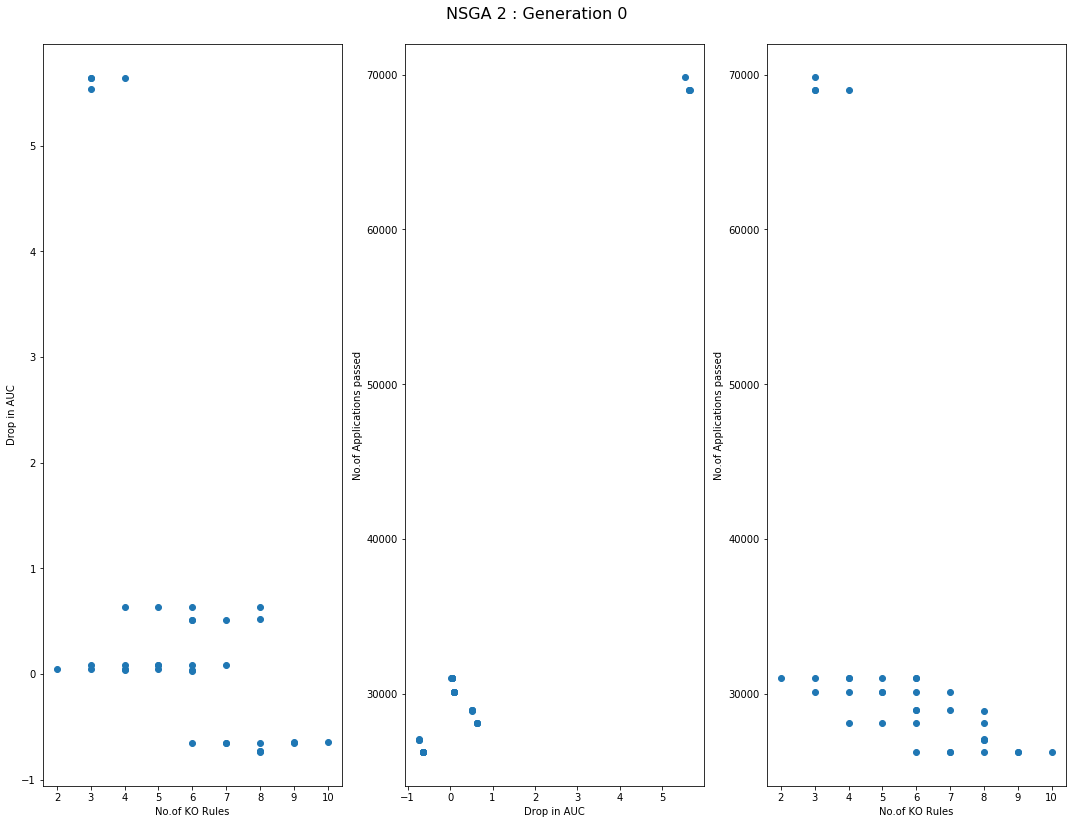

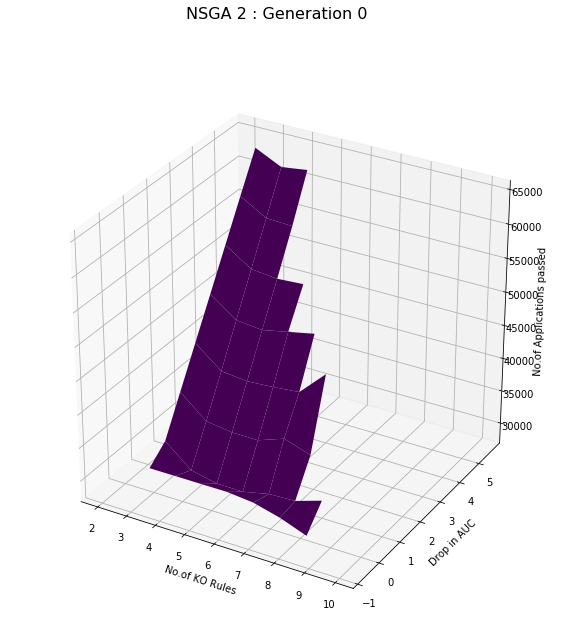

Generation 5 out of 20 


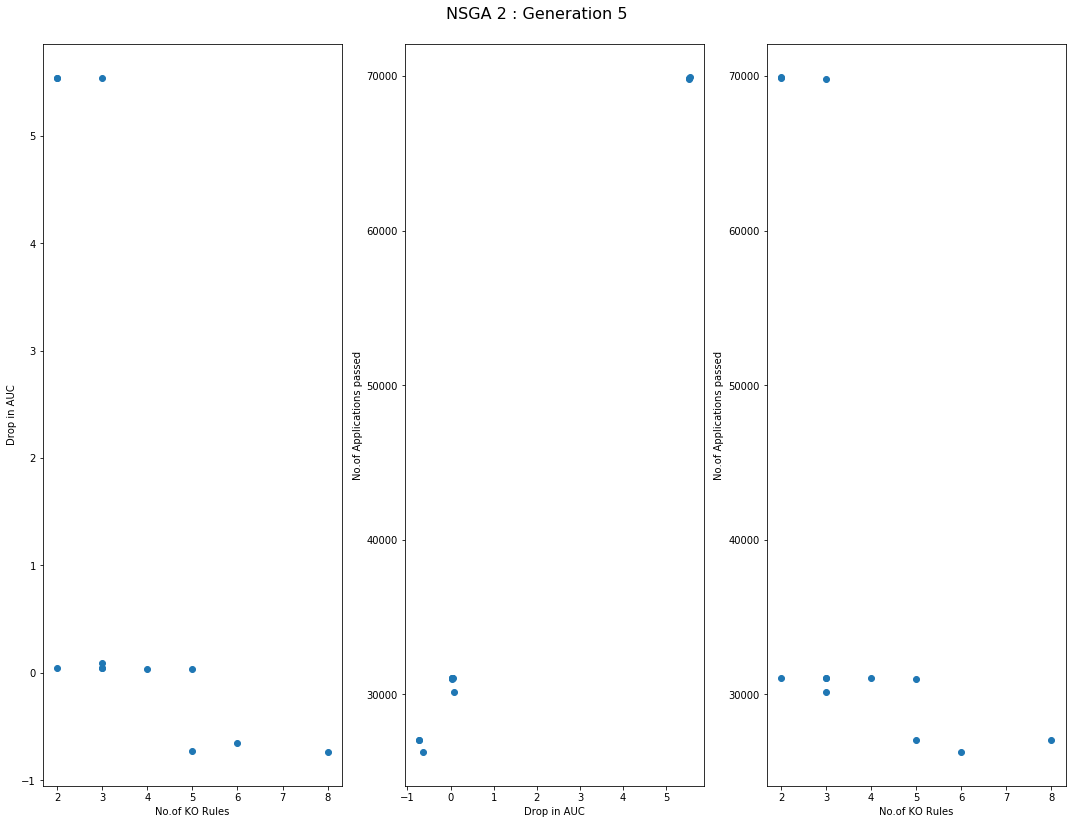

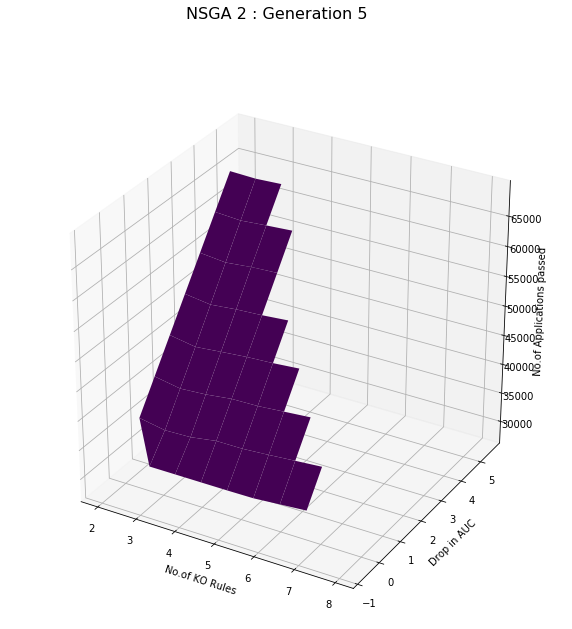

Generation 10 out of 20 


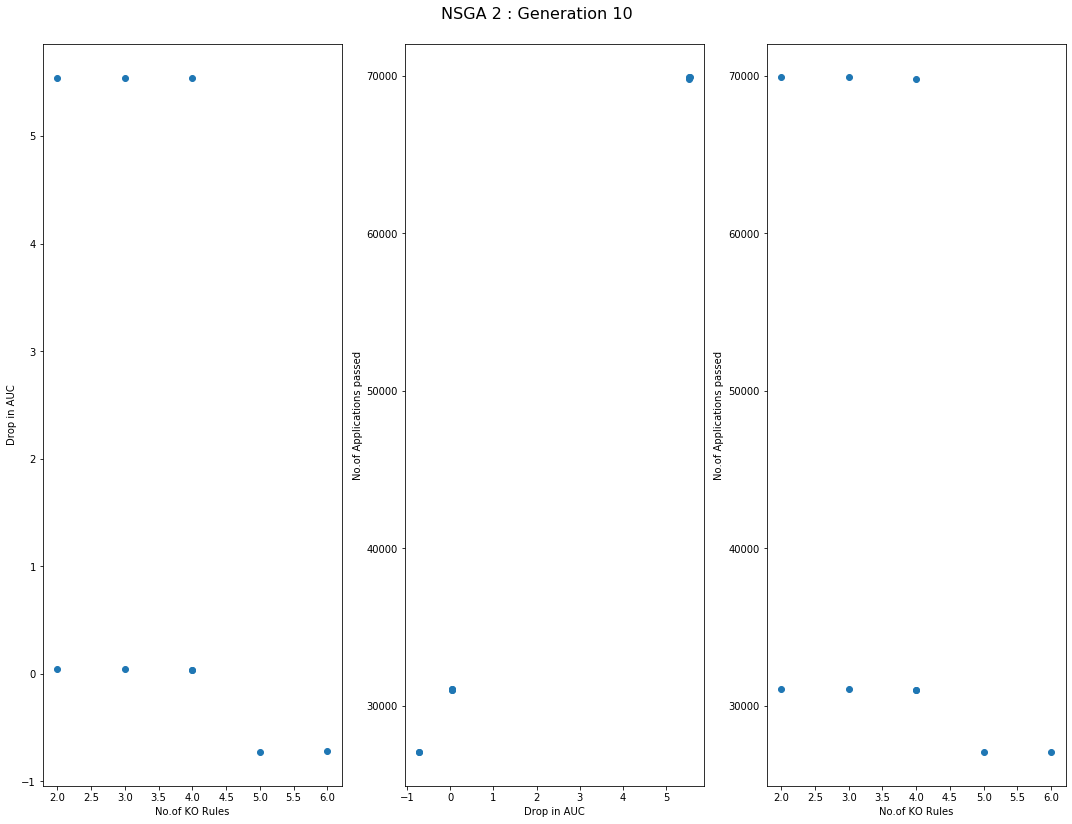

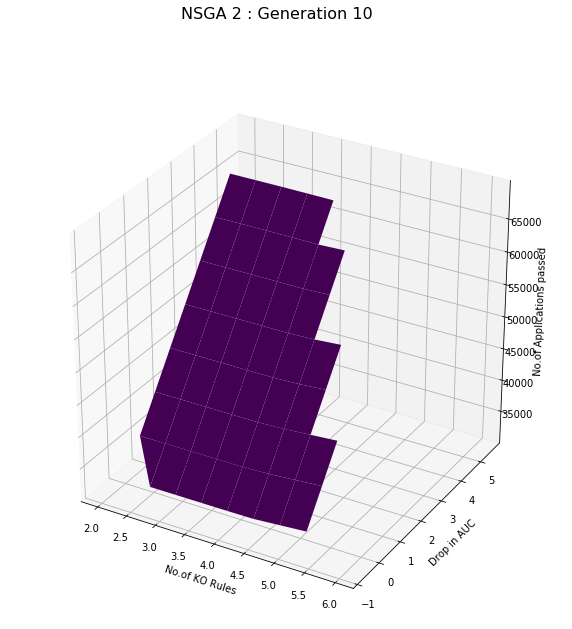

Generation 15 out of 20 


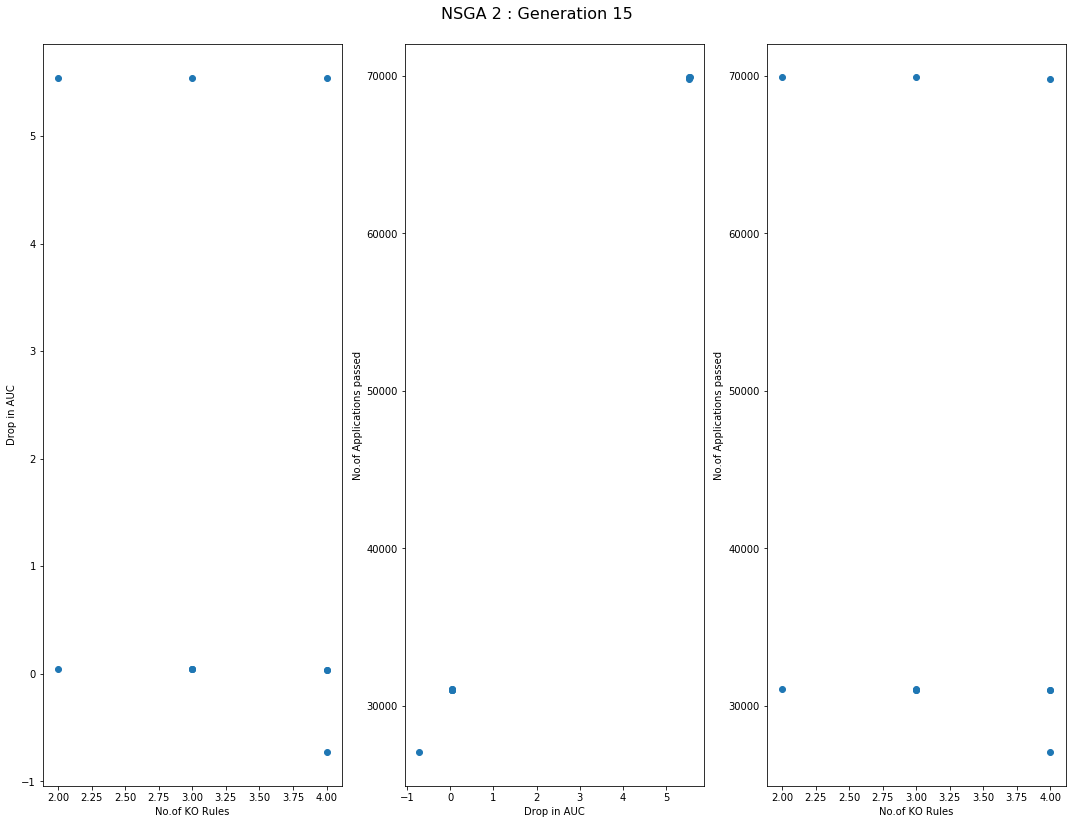

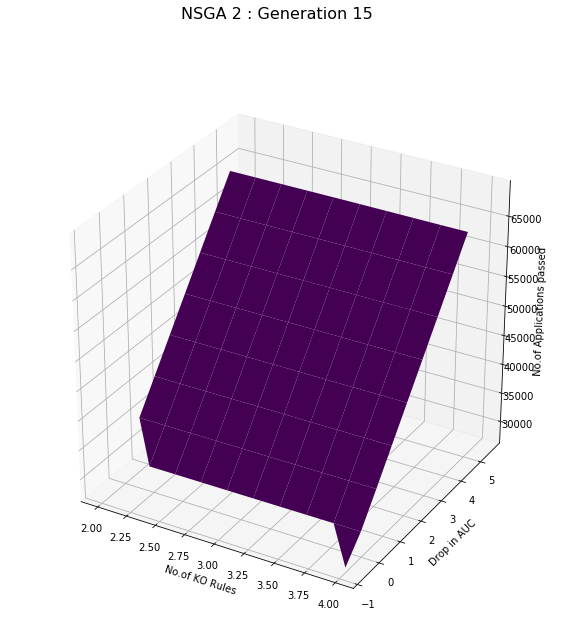

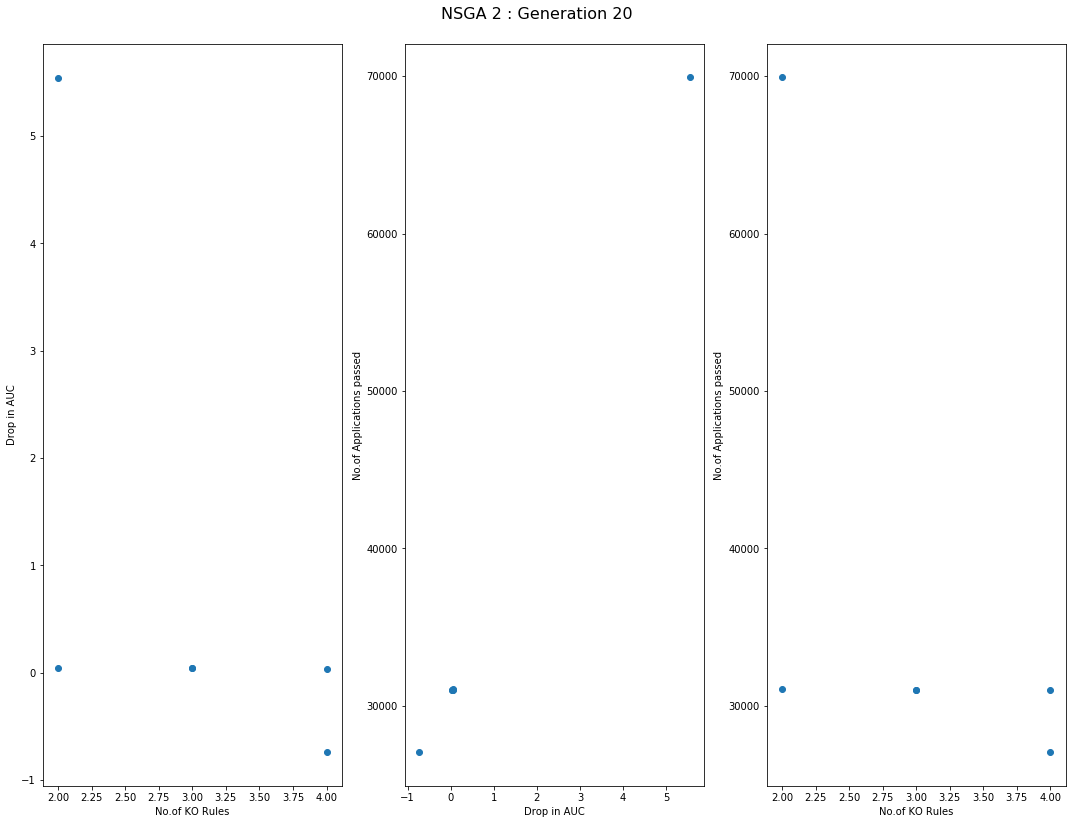

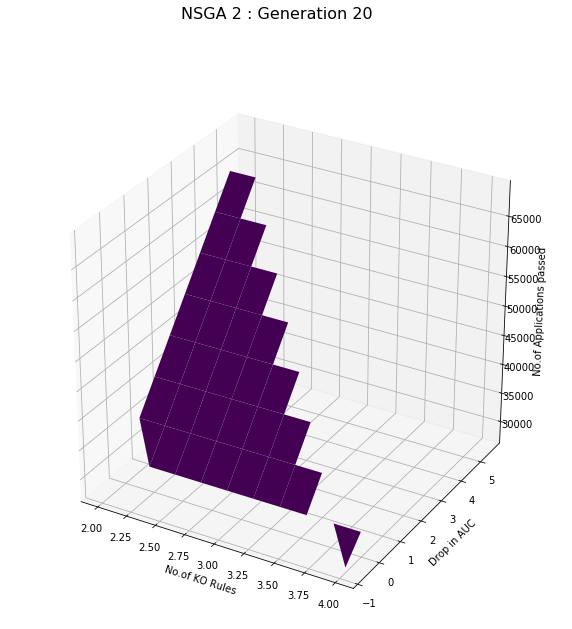

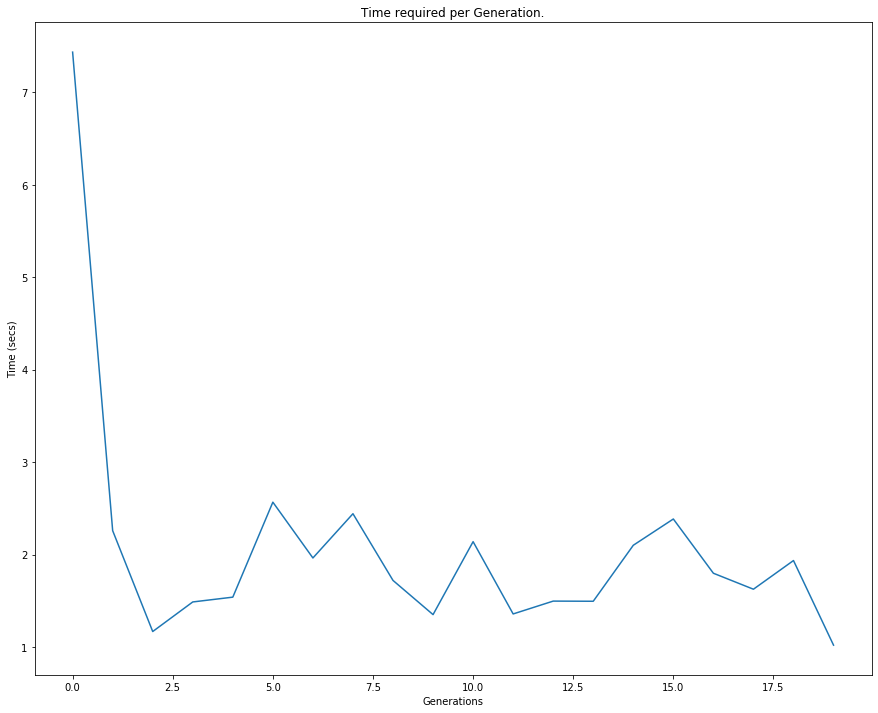

In [4]:
# Set general parameters
chromosome_length = len(all_rule_individual)
starting_population_size = 20
maximum_generation = 20
minimum_population_size = 5
maximum_population_size = 10
constraints=["No.of KO Rules","Drop in AUC","No.of Applications passed"]

# Create starting population
population = ngsa2.create_population(starting_population_size,chromosome_length)
population = np.unique(population, axis=0)
# Now we'll go through the generations of genetic algorithm

generation_list = []
time_required = []

for generation in range(maximum_generation):
    start_time = time.time()
    
    # Breed
    population = ngsa2.breed_population(population)
    
    # Score population
    population,scores = ngsa2.score_population_with_trained_clf(X_optimize,y_optimize,
                                                                trained_model,population)
    
    # Build pareto front
    population = ngsa2.build_pareto_population(
            population, scores, minimum_population_size, maximum_population_size)
    
    if generation%5 == 0:
        print ('Generation {} out of {} '.format(generation,maximum_generation))
        ngsa2.plot_2d_paretofront(scores,generation,constraints)
        ngsa2.plot_3d_paretofront(scores,generation,constraints)
    
    time_taken = time.time()-start_time
    #print("{} secs for Generation {} ".format(time_taken,generation))
    
    generation_list.append(generation)
    time_required.append(time_taken)
    

# Get final pareto front
population,scores = ngsa2.score_population_with_trained_clf(X_optimize,y_optimize,
                                                            trained_model,population)
population_ids = np.arange(population.shape[0]).astype(int)
pareto_front = ngsa2.identify_pareto(scores, population_ids)
population = population[pareto_front, :]
scores = scores[pareto_front]

#Selected Population
ngsa2.plot_2d_paretofront(scores,generation+1,constraints)
ngsa2.plot_3d_paretofront(scores,generation+1,constraints)

#Plot time taken for calculation.
ngsa2.plot_gen_time(generation_list,time_required)

### Final Results

In [5]:
ngsa2.show_population_score_df(population,scores)

,#Rules,AUC Diff,No.ofApplications,Rules
4,4.0,0.036553,31022.0,"{2.0: 'ltv <= 95', 7.0: 'new_accts_in_last_six_months <= 10', 8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10'}"
1,3.0,0.041556,31033.0,"{2.0: 'ltv <= 95', 8.0: 'perform_cns_score >= 200', 10.0: 'amt_rejected <= 0.7'}"
2,3.0,0.043462,31046.0,"{2.0: 'ltv <= 95', 8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10'}"
0,2.0,0.047398,31054.0,"{2.0: 'ltv <= 95', 8.0: 'perform_cns_score >= 200'}"
5,4.0,0.735586,27075.0,"{2.0: 'ltv <= 95', 6.0: 'avg_acct_age_m >= 6', 8.0: 'perform_cns_score >= 200', 9.0: 'pri_overdue_accts <=10'}"
3,2.0,5.541980,69921.0,"{2.0: 'ltv <= 95', 7.0: 'new_accts_in_last_six_months <= 10'}"
